<a href="https://colab.research.google.com/github/jt-ut/GaiaREU/blob/main/GaiaREU-ML_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Welcome to REU's ML Workshop

Intro

Workflow: Exploratory Data Analysis, Unsupervised vs. Supervised ML

Data Description: Gaia XpSampledMeanSpectrum, briefly discuss pre-processing (unit normalization)

In [9]:
## Install additional Python packages
!pip install umap-learn yellowbrick

## Import required modules
# For data wrangling
import pandas as pd
import numpy as np
# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
# Dimensionality Reduction & Testing
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.neighbors import KDTree


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=a2731dc539527747d81061b28142ea71bd86fbb8930a9408e333ba2484b9dae7
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=6e47de925ceb5333e8f85392abfc7e2f5bd0b6a9450f5b8bcbe0a4a08bfb5902
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [11]:
# Read data from web
flux = pd.read_csv('https://raw.githubusercontent.com/jt-ut/GaiaREU/main/GaiaREU_flux.csv', header=None)
wvl = pd.read_csv('https://raw.githubusercontent.com/jt-ut/GaiaREU/main/GaiaREU_wvl.csv', header=None)[0]

# Inspect the downloaded data
print(flux.shape)
print(flux.iloc[0])

print(wvl.shape)
print(wvl)

(3981, 343)
0      0.157631
1      0.140994
2      0.124082
3      0.120104
4      0.125592
         ...   
338    0.004656
339    0.004211
340    0.004113
341    0.004181
342    0.004694
Name: 0, Length: 343, dtype: float64
(343,)
0        1
1        2
2        3
3        4
4        5
      ... 
338    339
339    340
340    341
341    342
342    343
Name: 0, Length: 343, dtype: int64


Our flux data is arranged into a 3,981 row $\times$ 343 column ***data matrix***.

Each row represents an individual source (emitter of light) in the Gaia archive, and each column holds the flux measurements of that source at the 343 different wavelengths stored in the $wvl$ vector. Our data is actually flux from a model fit (not the actual observation) measured at 343 *pseudo*-wavelengths, represented by the sequential integers in the wvl vector.

FYI, almost all statistical and machine learning algorithms expect a data matrix arranged as above, with ***observations*** contained in its rows and ***variable measurements*** in its columns.

Let's plot some of our flux data just to get an idea of what these 343-dimensional vectors might look like.

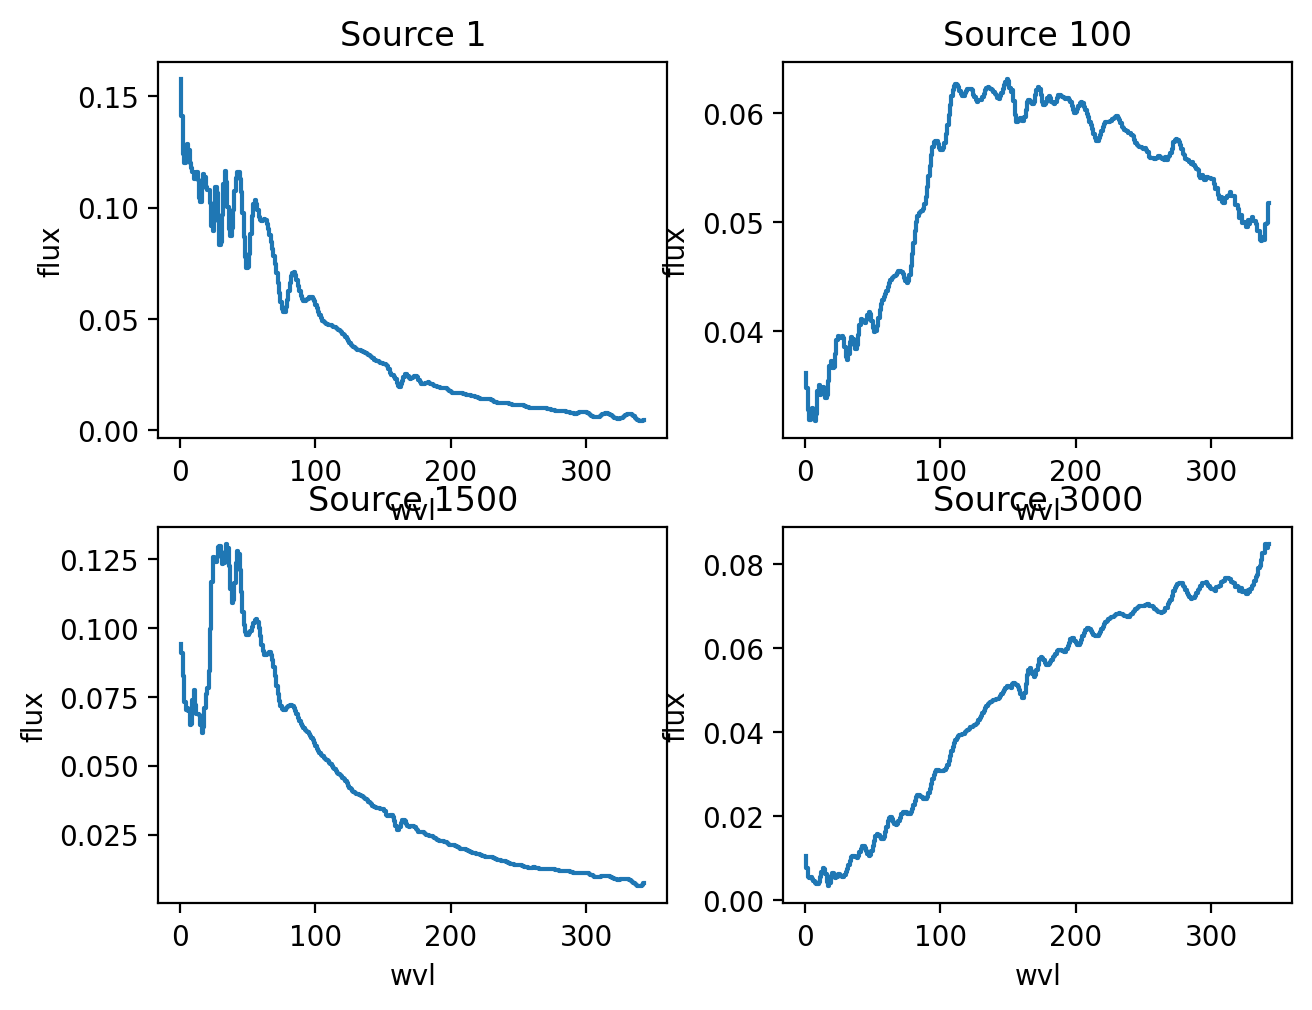

In [12]:
# Plot a few source spectra
plt.rcParams['figure.dpi'] = 200
fig, axes = plt.subplots(2, 2)
fig.tight_layout()
sns.lineplot(x = 'wvl', y = 'flux', data = pd.DataFrame({'wvl': wvl, 'flux': flux.iloc[0]}), drawstyle='steps-pre', ax=axes[0,0]).set(title='Source 1')
sns.lineplot(x = 'wvl', y = 'flux', data = pd.DataFrame({'wvl': wvl, 'flux': flux.iloc[99]}), drawstyle='steps-pre', ax=axes[0,1]).set(title='Source 100')
sns.lineplot(x = 'wvl', y = 'flux', data = pd.DataFrame({'wvl': wvl, 'flux': flux.iloc[1499]}), drawstyle='steps-pre', ax=axes[1,0]).set(title='Source 1500')
sns.lineplot(x = 'wvl', y = 'flux', data = pd.DataFrame({'wvl': wvl, 'flux': flux.iloc[2999]}), drawstyle='steps-pre', ax=axes[1,1]).set(title='Source 3000')
plt.show()

What we have just done, plotting actual data vectors in their native space, is called ***data visualiation***. Visualizing your data is probably the easiest, and most intuitive, part of ***exploratory data analysis***, which allows us to get a crude summary of what's "going on" in our data. For example, our plots above indicate that the sources in our sample have drastically different spectral profiles.


##Dimensionality Reduction

But does each source have a (meaningfully) different spectra, or could there be groups of sources with similar spectra? Since we can't realistically visualize the 343-dim spectra of all 3,000+ sources in our sample, we will instead build a *representation* of our data and visualize that. *Dimensionality Reduction* is the process of representing high-dimensional data in a lower dimensional space, usually 2-d or 3-d, for easy visualization. This is also called ***embedding*** our data.

There are many DR algorithms in statistics and machine learning. We introduce a few of the most common below:

### PCA

No parameters

### t-SNE

t-distributed Stochastic Neighbor Embedding ([t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)) attempts to place points in low-dimensional space such that similarities among their $k$-nearest high-dimensional neighbors are preserved. $k$ is a user-supplied parameter that t-SNE calls *perplexity*. t-SNE defines point-wise similarity as a (Gaussian) function of distance, and minimizes [Kullback-Leibler Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) to bring low-dim point similarites in line with their high-dim counterparts.

### UMAP

Uniform Manifold Approximation & Projection ([UMAP](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html)) is built upon the same idea as t-SNE, except it defines its high-dim and low-dim similarities differently (but still as a function of distance), and then attempts to find low-dim points which minimize the [Cross-Entropy](https://en.wikipedia.org/wiki/Cross_entropy) between themselves and their high-dim counterparts. UMAP also needs a user-supplied parameter it calls *n_neighbors*, which controls how many point-wise similarities should be preserved in low-dim.

Let's perform Dimensionality Reduction on our flux data and see how each of the above algorithms places our points in a plane.

In [ ]:
## PCA, no parameters needed!
pca = PCA(n_components=2)
X_pca = pca.fit_transform(flux)
X_pca = pd.DataFrame(X_pca, columns = ['x','y'])

## t-SNE, using default perplexity = 30
tsne = TSNE(n_components=2, perplexity=30.0, random_state = 123, verbose=1, n_jobs=2)
X_tsne = tsne.fit_transform(flux)
X_tsne = pd.DataFrame(X_tsne, columns = ['x','y'])

## UMAP, using its default n_neighbors = 15
umap = umap.UMAP(n_neighbors=15, n_components=2, n_jobs = 2, random_state=123, verbose=True)
X_umap = umap.fit_transform(flux)
X_umap = pd.DataFrame(X_umap, columns = ['x','y'])


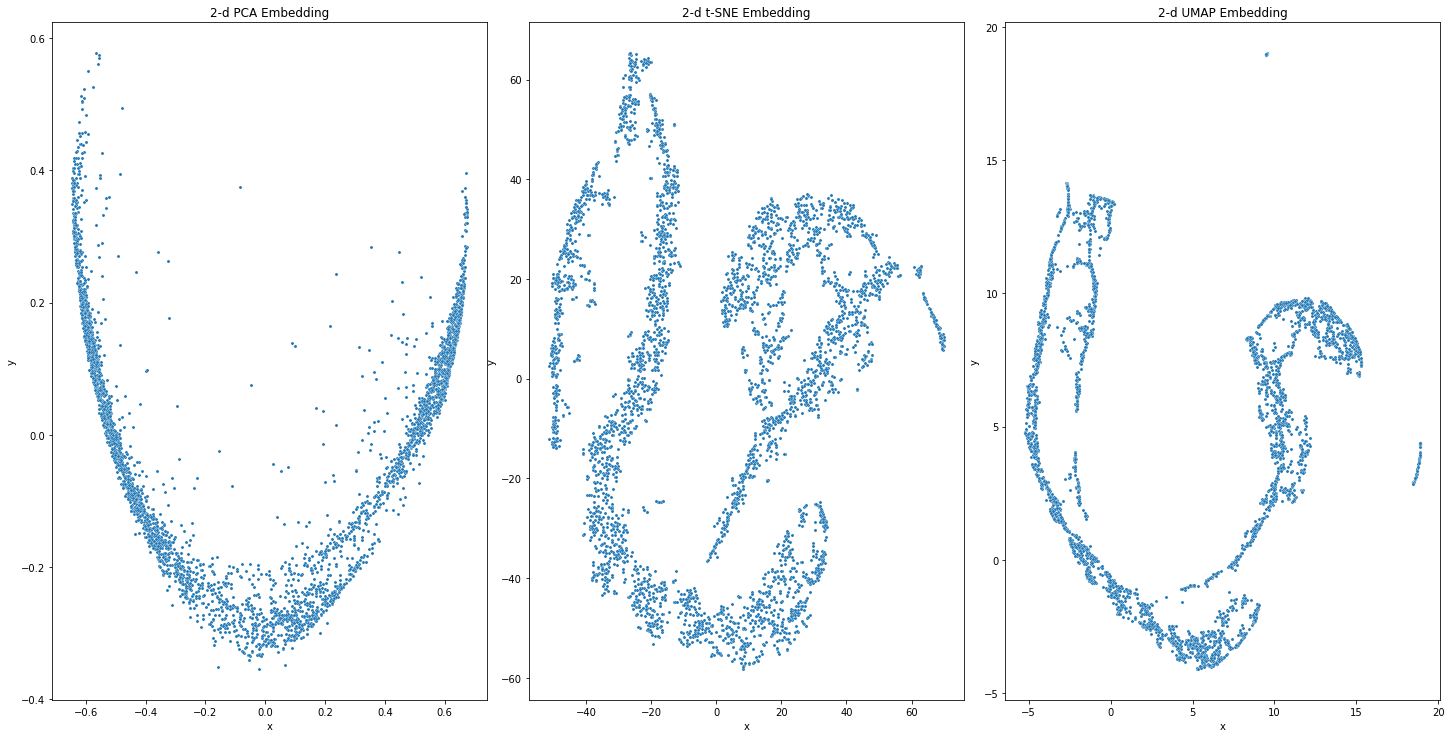

In [17]:
## Visualize the PCA, t-SNE, and UMAP representations of our flux data
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = (20,10)
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
sns.scatterplot(x='x', y='y', data = X_pca, s=10, ax=axes[0]).set(title='2-d PCA Embedding')
sns.scatterplot(x='x', y='y', data = X_tsne, s=10, ax=axes[1]).set(title='2-d t-SNE Embedding')
sns.scatterplot(x='x', y='y', data = X_umap, s=10, ax=axes[2]).set(title='2-d UMAP Embedding')
plt.show()

Based on these representations, does our data appear to be completely random, or does it have any meaningful ***structure***?

Based on how PCA, t-SNE, and UMAP work, what do you think any 2-d structure visible in the above might suggest about our 343-d flux data?

## Kernel Smoothing

It is usually hard, and generally a bad idea, to draw too many conclusions about your dataset by scrutinizing individual points.  This is because almost all real-world datasets contain ***noise***, and when you pick a few points at random from your sample you cannot be reasonably certain whether they are, or are not, noise.

The field of statistics offers many tools to help us "see" signals despite the presence of noise. One of these is called ***kernel smoothing***, or ***kernel density estimation***. The idea is to build a smoothed representation of the ***data density*** (number of points in a fixed area / volume) from which we can draw conclusions about our data.

Let's see what a smoothed version of our DR visualizations looks like.

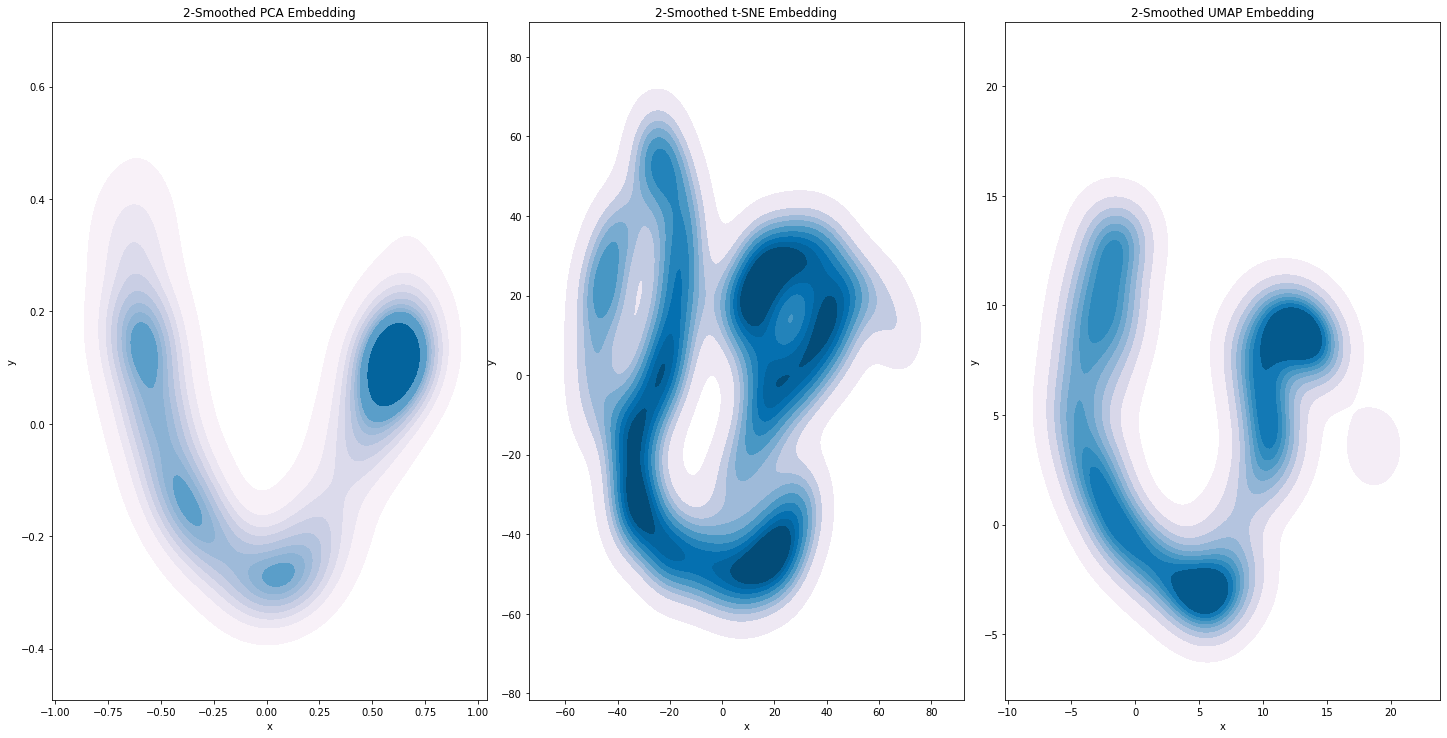

In [20]:
## Smoother visualizations of our embedded flux data
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = (20,10)
fig, axes = plt.subplots(1, 3)
fig.tight_layout()
sns.kdeplot(data=X_pca, x='x', y='y', fill = True, cmap = "PuBu", ax=axes[0]).set(title='2-Smoothed PCA Embedding')
sns.kdeplot(data=X_tsne, x='x', y='y', fill = True, cmap = "PuBu", ax=axes[1]).set(title='2-Smoothed t-SNE Embedding')
sns.kdeplot(data=X_umap, x='x', y='y', fill = True, cmap = "PuBu", ax=axes[2]).set(title='2-Smoothed UMAP Embedding')
plt.show()

Darker colors in the above heatmaps represent areas of higher data density, meaning more points are packed more tightly in these regions.

Do you see more structure than in the scatterplots we made above? Is it easier to see?

In [114]:
import numpy as np


flux_neighbors = KDTree(flux).query(X=flux, k=30)[1]
pca_neighbors = KDTree(X_pca).query(X=X_pca, k=30)[1]
tsne_neighbors = KDTree(X_tsne).query(X=X_tsne, k=30)[1]
umap_neighbors = KDTree(X_umap).query(X=X_umap, k=30)[1]

prop_pres_pca = 0
prop_pres_tsne = 0
prop_pres_umap = 0
N = flux.shape[0]
for i in range(N):
  prop_pres_pca += np.intersect1d(flux_neighbors[i], pca_neighbors[i]).size / 30
  prop_pres_tsne += np.intersect1d(flux_neighbors[i], tsne_neighbors[i]).size / 30
  prop_pres_umap += np.intersect1d(flux_neighbors[i], umap_neighbors[i]).size / 30

prop_pres_pca /= N
prop_pres_tsne /= N
prop_pres_umap /= N

print("Proportion of k-nearest neighbors preserved: pca = %.2f, t-SNE = %.2f, UMAP = %.2f\n" % (prop_pres_pca, prop_pres_tsne, prop_pres_umap))

Proportion of k-nearest neighbors preserved: pca = 0.46, t-SNE = 0.64, UMAP = 0.59



In [117]:
!pip install hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 26.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp310-cp310-linux_x86_64.whl size=3541956 sha256=1eec5a76178f17683594a758e5bf90a6c9960b93682b316bfd23c1522e73f9b7
  Stored in directory: /root/.cache/pip/wheels/dc/52/e3/6c6b60b126b4d5c4370cb5ac071b82950f91649d62d72f7f56
Successfully built hdbscan


In [125]:
import hdbscan

clusterer = hdbscan.HDBSCAN()
clusterer.fit(X_umap)


HDBSCAN()

In [126]:
np.unique(clusterer.labels_)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158])

In [138]:
from sklearn.cluster import OPTICS

clustering = OPTICS(min_samples=2, algorithm = 'kd_tree').fit(X_umap)
np.unique(clustering.labels_)

from sklearn.cluster import MeanShift, estimate_bandwidth
#bandwidth = estimate_bandwidth(X_pca, quantile=0.2, n_samples=500)
ms = MeanShift().fit(X_umap)




In [139]:
np.unique(ms.labels_)

array([0, 1, 2, 3])

In [133]:
import statsmodels.api as sm

dens_u = sm.nonparametric.KDEMultivariate(data=X_pca, var_type='cc', bw='cv_ml')
dens_u.bw

/usr/local/lib/python3.10/dist-packages/statsmodels/nonparametric/kernel_density.py:158: RuntimeWarning: invalid value encountered in log


KeyboardInterrupt: ignored

In [140]:
!pip install yellowbrick

In [1]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering



#model = KMeans()
model = AgglomerativeClustering(linkage='single')
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,20), metric = 'silhouette', timings= True)
visualizer.fit(X_tsne)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

NameError: ignored